# Approaches to Agricultural Optimization

## Variable Definitions

- $N$ crops belonging to $N_f$ families
- $L$ number of lots
- $M$ number of months
- $C = [c_1, ... c_N]$ is the set of crops
- $F_p = \{c_i, c_j, ...\}$ is set of crops in same family p
- $R_i$ is revenue of crop i based on price/unit
- $S_k$ is set of crops adjacent to lot $k$
- $A_k$ area of lot k
- $T_i$ growing time of crop i
- $x_{ijk} = \begin{cases} 1, & \mbox{if crop i is planted on lot k in month j} \\ 0, & \mbox{otherwise} \end{cases}$

## Mathematical Formulation

The goal is to maximize the revenue generated according to the equation: $z = \sum_{i \in C} \sum_{j=1}^M \sum_{k=1}^L (A_k\cdot R_i\cdot x_{ijk})$

While respecting the constraints farmers are subject to:

$\sum_{i \in F_p}\sum_{j=1}^M\sum_{v \in S_k} (x_{ijv}) \le L(1 - \sum_{j=1}^M\sum_{i \in F_p} x_{ijk})$ where $k=1,...,L$ and $p=1,...,N_f$

$\sum_{i\in F_p}\sum_{r=0}^{t_i} x_{i(j-r)k} \le 1$ where $p=1,...,N_f$, $k=1,...,L$, and $j=1,...,M$

$\sum_i^N x_{ijk} \le 1$ where $k=1,...,L$

The fitness function chosen is a dampened exponential penalty function: $z(S) = z(S)\cdot e^{-\rho/\phi}$ where $\rho$ is the sum of all penalizations and $\phi$ is a hyperparameter

## Data and Problem Generation

In [2]:
#divides a given area randomly into smaller rectangular plots
function build_greenhouse(r,c,hcuts=3,vcuts=4, debug=false)
    L = (hcuts+1)*(vcuts+1)
    gh = zeros(Int,r,c)
    areas = []
    v = []
    while length(v) < vcuts
        cut = rand(1:20)
        if !(cut in v)
            push!(v,cut)
        end
    end
    h = []
    while length(h) < hcuts
        cut = rand(1:20)
        if !(cut in h)
            push!(h,cut)
        end
    end
    v = sort(cat(v,[c],dims=1))
    h = sort(cat(h,[r],dims=1))
    
    temph=1
    p = 1
    for hcut in h
        tempv=1
        for vcut in v
            gh[temph:hcut,tempv:vcut] .= p
            push!(areas, (hcut-temph+1)*(vcut-tempv+1))
            tempv = vcut + 1
            p += 1
        end
        temph = hcut + 1
    end
    
    neighbors = Array{Array{Any,1},1}(undef,L)
    for i=1:L
        temp = []
        if i > vcuts+1
            push!(temp, i-5)
        end
        if (i-1)%(vcuts+1) != 0
            push!(temp,i-1)
        end
        if i%(vcuts+1) != 0
            push!(temp,i+1)
        end
        if i < L - vcuts
            push!(temp,i+5)
        end
        neighbors[i] = temp
    end
    
    if debug==true
        return gh
    end
    return areas,neighbors
end

build_greenhouse (generic function with 4 methods)

In [3]:
L = 20 #number of lots
N = 19 #number of plants
Nf = 9 #number of plant families
A_k,S_k = build_greenhouse(20,20) #areas,adjacent crops
#profitability of each crop ($/acre)
l_i = [[0,0,8815.2,8815.2,8815.2,8815.2,8815.2,0,0,0,0,0],
        [0,7815.,7815.,7815.,7815.,7815.,7815.,7815.,7815.,7815.,0,0],
        [0,0,10175.2,10175.2,10175.2,10175.2,10175.2,10175.2,0,0,0,0],
        [0,0,1100.18,1100.18,1100.18,1100.18,0,0,0,0,0,0],
        [8000.8,8000.8,8000.8,0,0,8000.8,8000.8,8000.8,0,0,0,0],
        [17118.98,17118.98,17118.98,17118.98,17118.98,17118.98,17118.98,17118.98,17118.98,17118.98,17118.98,17118.98],
        [0,0,0,0,0,1648.,1648.,1648.,1648.,0,0,0],
        [4449.,4449.,4449.,4449.,4449.,4449.,4449.,4449.,4449.,4449.,4449.,4449.],
        [450.,450.,450.,450.,450.,450.,450.,450.,0,0,0,450.],
        [0,0,524.49,524.49,524.49,524.49,524.49,0,0,0,0,0],
        [0,0,0,0,0,0,0,915.53,915.53,915.53,915.53,915.53],
        [0,0,0,0,0,605.2,605.2,605.2,605.2,605.2,0,0],
        [238.56,0,0,0,0,0,0,0,238.56,238.56,238.56,238.56],
        [0,0,190.74,190.74,190.74,190.74,190.74,190.74,190.74,190.74,0,0],
        [5845.,5845.,5845.,5845.,5845.,5845.,5845.,5845.,5845.,5845.,5845.,5845.],
        [0,0,0,0,0,0,4500.,4500.,4500.,4500.,4500.,4500.],
        [14604.48,14604.48,14604.48,14604.48,14604.48,14604.48,14604.48,14604.48,14604.48,14604.48,14604.48,14604.48],
        [0,0,19646.98,19646.98,19646.98,19646.98,19646.98,19646.98,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0]] 
F_p = [[1,2,3],[4,5],[6],[7,8],[9,10,11],[12,13,14],[15,16,17],[18],[19]] #crops in same family
M = 12 #number of months
t_i = [4,7,4,2,2,2,3,4,4,3,3,3,3,6,5,3,5,4,1] #time period for each crop, in months; t_i < M
dfp = Dict(1=>1,2=>1,3=>1,4=>2,5=>2,6=>3,7=>4,8=>4,9=>5,10=>5,11=>5,12=>6,13=>6,14=>6,15=>7,16=>7,17=>7,
    18=>8,19=>9); #dictionary of crop->family

## Genetic Algorithm Implementation

In [4]:
# package imports
using Dates
using Printf
using Statistics
using PrettyTables

In [5]:
function plant_field(L,M,N)
    field = zeros(Int,L,M)
    for k=1:L
        p = 1
        while 0 in field[k,:]
            crop = rand(1:N)
            time = t_i[crop]
            if time <= M - p + 1
                for x=p:time+p-1
                    field[k,x] = crop
                end
                p += time
            end
        end
    end
    return field
end

plant_field (generic function with 1 method)

In [6]:
function fitness3(M, ϕ=8, debug=false)
    z = 0
    ρ = 0
    for time=1:size(M)[2]
        A = M[:,time]
        for k=1:length(A)
            z += A_k[k]*l_i[A[k]][time]
            #penalizes if more than one crop is grown on the same plot
            s = 0
            for i=1:N
                if A[k] == i
                    s += 1
                end
            end
            if s > 1
                ρ += 1
            end
            #penalizes for planting crops of the same family in adjacent plots
            for p=1:Nf
                f = 0
                n = L
                for i in F_p[p]
                    for v in S_k[k]
                        if A[v] == i
                            f += 1
                        end
                    end
                    if A[k] == i
                        n = 0
                    end
                end
                if f > n
                    ρ += 1
                end
            end
        end
    end
    #penalizes for planting crops of the same family one after another
    for plot=1:size(M)[1]
        B = M[plot,:]
        last = B[1]
        count = 0
        for l=1:length(B)
            if B[l] != last
                if dfp[B[l]] == dfp[last]
                    ρ += 1
                end
                count = 0
            else
                if count > t_i[B[l]]
                    ρ += 1
                end
            end
            count += 1
            last = B[l]
        end
    end
    
    if debug==true
        println(ρ)
    end
    return z*Base.MathConstants.e^(-ρ/ϕ)
end

fitness3 (generic function with 3 methods)

In [7]:
function weighted_roulette_wheel_selection3(A, n=10)
    fit = zeros(size(A)[3])
    best = -1
    for x=1:size(A)[3]
        fit[x] = fitness3(A[:,:,x])
        if best < fit[x]
            best = fit[x]
            elite1 = x
        end
    end
    total = sum(fit)
    ctot = 0
    for i=1:length(fit)
        fit[i] = (fit[i]/total) + ctot
        ctot = fit[i]
    end
    selected = zeros(Int, 50)
    #sorted = sortslices(A, dims=3, by=fitness, rev=true)
    elite1 = A[:,:,elite1]
    for x=1:n
        r = rand()
        i=1
        while fit[i] < r
            i+=1
        end
        selected[x] = i
    end
    return selected, elite1, size(A)[3]
end

weighted_roulette_wheel_selection3 (generic function with 2 methods)

In [8]:
function next_generation3(A, s; p=0.10, elite=[])
    evals = 1
    #crossover steps
    r,c = 10,L
    children = zeros(Int,c,12,r+1)
    for i=1:div(r,2)
        sp = rand(1:c-1)
        children[:,:,2*i-1] = cat(A[1:sp,:,s[2*i-1]], A[sp+1:c,:,s[2*i]], dims=1)
        children[:,:,2*i] = cat(A[sp+1:c,:,s[2*i-1]], A[1:sp,:,s[2*i]], dims=1)
    end
    #mutation steps
    for x=1:r
        for y=1:c
            if rand() < p
                children[y,:,x] = plant_field(1,12,N)
                evals += 1
            end
        end
    end
    #elitism step
    if elite != []
        children[:,:,r+1] = elite
    end
    return children,evals
end

next_generation3 (generic function with 1 method)

In [9]:
abstract type metaheuristic end
mutable struct geneticAlgorithm <: metaheuristic end

function run3!(GA::geneticAlgorithm, start, epochs=1e3, n_same=1e3)
    time = Dates.now(UTC)
    n_epochs = 1
    best = []
    staling = 1
    fevals=0
    generation = copy(start)
    while n_epochs < epochs
        selected,elite,evals = weighted_roulette_wheel_selection3(generation)
        fevals += evals
        if best == elite
            staling += 1
        else
            best = elite
            staling = 1
        end
        if staling == n_same
            return best, [fitness3(best),n_epochs,fevals,Dates.value(Dates.now(UTC) - time)]
        end
        generation,evals = next_generation3(generation, selected, elite=elite)
        fevals += evals
        n_epochs += 1
    end
    return best, [fitness3(best),n_epochs,fevals,Dates.value(Dates.now(UTC) - time)]
end

run3! (generic function with 3 methods)

### Genetic Algorithm Statistics

In [10]:
function GA_stats(m)
    stats = []
    for i=1:20
        start = zeros(Int,20,12,50)
        for i=1:50
            start[:,:,i] = plant_field(20,12,19)
        end
        ga = geneticAlgorithm()
        crops,s = run3!(ga,start,m)
        for j=1:4
            push!(stats,s[j])
        end
    end
    pstats = permutedims(reshape(stats, (4,20)))
    std_f = std(pstats, dims=[1 1 1 1])
    mean_f = mean!([1. 1. 1. 1.], pstats)
    format = String[]
    push!(format, string(m))
    for s=1 : 4
        push!(format, @sprintf("%.4E ± %.4E", mean_f[s], std_f[s]))
    end
    return format
end

GA_stats (generic function with 1 method)

In [11]:
stats_10 = reshape(GA_stats(10), (1,5))
stats_50 = reshape(GA_stats(50), (1,5))
stats_100 = reshape(GA_stats(100), (1,5))
stats_500 = reshape(GA_stats(500), (1,5))
table = permutedims(reshape([stats_10 stats_50 stats_100 stats_500], (5,4)))
pretty_table(table, ["MaxIter", "Revenue", "Epochs", "Fevals", "Time (ms)"]; backend=:html)

MaxIter,Revenue,Epochs,Fevals,Time (ms)
10,3.6100E+05 ± 4.4392E+05,1.0000E+01 ± 0.0000E+00,3.3055E+02 ± 1.2475E+01,4.7870E+02 ± 6.9246E+01
50,6.1873E+06 ± 6.4607E+06,5.0000E+01 ± 0.0000E+00,1.6009E+03 ± 3.0727E+01,2.1507E+03 ± 3.8740E+02
100,1.2137E+07 ± 7.2449E+06,1.0000E+02 ± 0.0000E+00,3.2298E+03 ± 3.8625E+01,3.8579E+03 ± 3.8985E+02
500,3.0090E+07 ± 7.8643E+06,5.0000E+02 ± 0.0000E+00,1.5998E+04 ± 9.1047E+01,1.8534E+04 ± 5.7974E+02


### Sample Execution

In [12]:
#generate a starting generation
start = zeros(Int,20,12,50)
for i=1:50
    start[:,:,i] = plant_field(20,12,19)
end
#create an instance of the algorithm
ga = geneticAlgorithm()
#run the algorithm
crops,s = run3!(ga,start)
#print the revenue/fitness value
println(fitness3(crops))

3.8127282060000055e7


## Simulated Annealing Implementation

In [1]:
#package imports
using Colors
using Plots
using Random

function simulated_annealing(f, x, T, t, k_max, month)
    y = f(x)
    x_best, y_best = x, y
    for k in 1 : k_max
        dims = size(x[1])
        x′ = T(dims[1],dims[2],month)
        y′ = f(x′)
        Δy = y′ - y
        if Δy ≤ 0 || rand() < exp(-Δy/t(k))
            x, y = x′, y′
        end
        if y′ < y_best
            x_best, y_best = x′, y′
        end
    end
    return x_best
end

┌ Info: Precompiling Colors [5ae59095-9a9b-59fe-a467-6f913c188581]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


simulated_annealing (generic function with 1 method)

In [2]:
abstract type crop end 
mutable struct plant <: crop
    name
    family
    profit
    monthsleft
    color
end

function init!(M::plant, name, family, profit, monthsleft,color)
    M.name = name
    M.family = family
    M.profit = profit
    M.monthsleft = monthsleft
    M.color = color
    return M
end

init! (generic function with 1 method)

In [3]:
#set initial t
t0 = 1
#use fast annealing schedule
t = k -> t0/k

#1 (generic function with 1 method)

In [4]:
#for implementation of penalty function requires to know which plants are adjacent
function get_adjacent_plant(x, i)
    dims = size(x)
    array = plant[]
    xcoord = mod(i-1, dims[2])
    ycoord = (i-1)÷dims[1]
    if(xcoord > 0)
        push!(array,x[i-1])
    end
    if(xcoord < dims[2]-1)
        push!(array, x[i+1])
    end
    if(ycoord > 0)
        push!(array, x[i - dims[2]])
    end
    if(ycoord < dims[1]-1)
        push!(array, x[i + dims[2]])
    end
    return array
end

get_adjacent_plant (generic function with 1 method)

In [5]:
Spring = [plant("Soybean", "Leguminosae",50,4, RGB(127/255,0,1.0)),plant("Lettuce","Compositae",47.29*362,2, RGB(0,0,0)),
        plant("Tomato", "Solanaceae",6.68*875,5,RGB(1.0,1/2,0)), plant("Cucumber", "Cucurbitae",30*148.3,4, RGB(0,0,204/255)), 
        plant("Peas","Leguminosae",13.46*39,3,RGB(153/255,1/5,1)),plant("Cauliflower","Brassicaceae", 46.30*221.2, 4, RGB(76/255,153/255,0)),
        plant("Carrots","Umbelliferae", 31.40*625.7,4,RGB(1/2,1/2,1/2)), plant("Beets","Chenopodiaceae", 1100, 2,RGB(153/255,0,0)),
        plant("Oats","Poaceae",190,6,RGB(1,1,2/5)), plant("Cabbage","Brassicaceae",8815, 4,RGB(51/255,102/255,0)),
        plant("empty", "none",0,1, RGB(1,1,1))]

Summer = [plant("Lettuce","Compositae",47.29*362,2, RGB(0,0,0)),plant("Tomato", "Solanaceae", 6.68*875,5,RGB(1,1/2,0)), 
        plant("Cucumber", "Cucurbitae",30*148.3,4, RGB(0,0,204/255)),plant("Corn", "Poaceae", 3.4*178, 3,RGB(1,1,0)), 
        plant("Potato","Solanaceae", 4500,3,RGB(1,3/5,1/5)), plant("Watermelon","Cucurbitae", 1648,3,RGB(0,0,153/255)), 
        plant("Bellpeppers", "Solanaceae", 14604,5,RGB(1,178/255,2/5)),plant("empty", "none",0,1, RGB(1,1,1))]

Fall = [plant("Lettuce","Compositae",47.29*362,2, RGB(0,0,0)),plant("Tomato", "Solanaceae", 6.68*875,5,RGB(1,1/2,0)), 
        plant("Cucumber", "Cucurbitae",30*148.3,4, RGB(0,0,204/255)), plant("Winter Wheat","Poaceae",4.80*49.7,3,RGB(1,1,1/5)),
        plant("Beans", "Leguminoae", 3, 915, RGB(178/255,2/5,1)),plant("empty", "none",0,1, RGB(1,1,1))]

Winter = [plant("Lettuce","Compositae",47.29*362,2, RGB(0,0,0)),plant("Tomato", "Solanaceae", 6.68*875,5,RGB(1,1/2,0)), 
        plant("Cucumber", "Cucurbitae",30*148.3,4, RGB(0,0,204/255)), plant("Soybean", "Leguminosae",50,4,RGB(127/255,0,1)), 
        plant("Broccoli","Brassicaceae",7815,7,RGB(102/255,204/255,0)), plant("Spinach", "Chenopodiaceae",8000, 2,RGB(204/255,0,0)),
        plant("empty", "none",0,1, RGB(1,1,1))]

function createplantmatrix(x, y, month)
    plantlist = retPList(month)
    n = length(plantlist)
    plantm = Matrix{plant}(undef, y, x)
    for i=1:x*y
        plant1 = plantlist[rand(1:n)]
        plant2 = deepcopy(plant1)
        plantm[i] = plant2
    end
    return plantm
end

function retPList(month)
    plist = []
    if month < 4
        plist = Spring
    elseif month < 7
        plist = Summer
    elseif month < 10
        plist = Fall
    else
        plist = Winter
    end
    return plist
end

function updateplantm(plantm,num,month)
    plantlist = retPList(month)
    n = length(plantlist)
    plant1 = plantlist[rand(1:n)]
    adj = get_adjacent_plant(plantm, num)
    plant2 = deepcopy(plant1)
    return plant2
end


updateplantm (generic function with 1 method)

In [6]:
function penaltyplant(x) 
    dims = size(x)
    total = dims[1]*dims[2]
    adjacents = 0
    for i = 1:total
        adjacent = get_adjacent_plant(x, i)
        for j = 1:length(adjacent)
            if(x[i].family == x[j].family)    
                adjacents+=1
            end
        end
    end
    return adjacents/total
end

function plotfield(plantm)
    dims = size(plantm)
    plantplot = Matrix{RGB{Float64}}(undef,dims[1],dims[2])
    for i=1:dims[1]*dims[2]
        plantplot[i] = plantm[i].color
    end
    display(plot(plantplot, reuse=false))
end

plotfield (generic function with 1 method)

In [7]:
function profitpath(path)
    profit = 0
    for i in path
        monthlyprofit=0
        for j in i
            if j.monthsleft == 1
                monthlyprofit += j.profit
            end
        end
        monthlyprofit /= (1 + penaltyplant(i))^2
        profit += monthlyprofit
    end
    return -profit
end

function profitplant(oplantmatrix)
    profit = 0
    plantmatrix = deepcopy(oplantmatrix)
    for i = 1:length(plantmatrix)
        profit += plantmatrix[i].profit
    end
    profit /= (1 + penaltyplant(plantmatrix))^2
    return -profit
end

function createpath(x,y,month)
    array = []
    plantmatrix = createplantmatrix(x,y,month)
    plantm = deepcopy(plantmatrix)
    push!(array,plantm)
    month = 1
    for i= 2:12
        for i = 1:length(plantmatrix)
            plantmatrix[i].monthsleft -= 1
            if plantmatrix[i].monthsleft <= 0
                plantmatrix[i] = updateplantm(plantmatrix,i,month)
            end
        end
        month+=1
        curr = deepcopy(plantmatrix)
        push!(array,curr)
    end
    return array
end

createpath (generic function with 1 method)

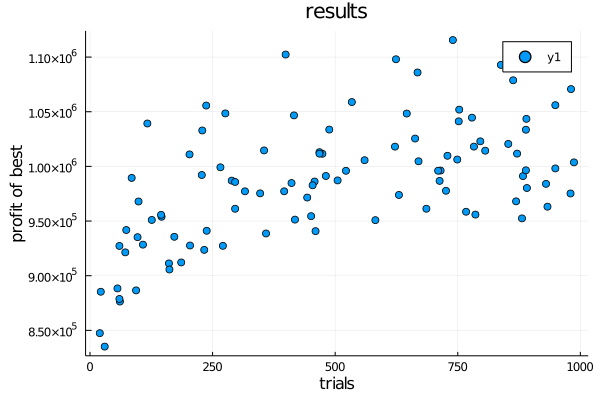

In [8]:
plantm = createpath(10,10,1)
x = []
y = []

#generate 100 points between 1 and 1000 trials and plot them
#this takes a few minutes usually

for j=1:100
    i = rand(1:1000)
    xbest = simulated_annealing(profitpath, plantm, createpath, t,i,1)
    money = profitpath(xbest)
    push!(x, i)
    push!(y, -money)
end

plot(x,y,seriestype = :scatter, title = "results")
xlabel!("trials")
ylabel!("profit of best")

In [9]:
#run on a sample 20x20 plant field
plantma = createpath(10,10,1)
xbest = simulated_annealing(profitpath, plantma, createpath, t, 10000, 1)
money = -profitpath(xbest)
print(money)
# for i in xbest
#     plotfield(i)
# end

1.0620776739348418e6